<a href="https://colab.research.google.com/github/SlickMik/ensf692Project/blob/main/ENSF_692_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%autosave 2

Autosaving every 2 seconds


# ESNF 692 Project
### Group # : 4
##### Authors : Danish Shahid () | Muhammad Ibrahim Khan ()
##### Date : June 19, 2025
---

This notebook closely analyzes how three major asset classes—Oil, Gold, and the S&P 500—perform with respect to one another in a time frame of your choice. It applies several analysis measures like smooth price trends, cumulative returns, market direction classification, asset correlation coefficients, monthly average returns, and alpha and beta calculations. By allowing users to define their own time horizon, the notebook provides an interactive way to plot long-term trends, analyze how these investments move in relation to one another, and study diversification and risk across asset classes.

---

Importing Libraries

In [3]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib as mp
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates

# Dataset Selection

Downloading Kaggle Datasets

In [4]:
# Download latest dataset versions
gold_dataset_path = kagglehub.dataset_download("faisaljanjua0555/daily-gold-price-historical-dataset")

oil_dataset_path = kagglehub.dataset_download("guillemservera/fuels-futures-data")

sp_dataset_path = kagglehub.dataset_download("youcanttouchthis/s-p-500-dataset")

100%|██████████| 87.0k/87.0k [00:00<00:00, 46.4MB/s]

Extracting files...


100%|██████████| 1.21M/1.21M [00:00<00:00, 105MB/s]

Extracting files...


100%|██████████| 179k/179k [00:00<00:00, 49.3MB/s]

Extracting files...


# Dataset Creation

* Reading Dataset to Pandas<br/>
* Dropping unnecessary columns<br/>
* Setting index to Date<br/>
* Parsing Date

In [5]:
# read csv files into pandas
gold_dataset = pd.read_csv(gold_dataset_path + f'/gold.csv', index_col='Date', parse_dates=True)

oil_dataset = pd.read_csv(oil_dataset_path + f'/all_fuels_data.csv', index_col='date', parse_dates=True)

sp_dataset = pd.read_csv(sp_dataset_path + f'/spy.csv', index_col='Date', parse_dates=True)

Gold Dataset
* Dropping Columns
* Renaming Columns

Describing Gold Dataset

In [6]:
gold_dataset = gold_dataset.drop(columns='Currency').rename(columns = {c : f'Gold_{c}' for c in gold_dataset.columns})
gold_dataset.head(3)

,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Volume
Date,,,,,
2000-01-04,289.5,289.5,280.0,283.7,21621
2000-01-05,283.7,285.0,281.0,282.1,25448
2000-01-06,281.6,282.8,280.2,282.4,19055


Oil Dataset
* Dropping Columns
* Reorganizing Columns
* Renaming Columns
* Cleaning Columns

Describing Oil Dataset

In [7]:
oil_dataset = oil_dataset[oil_dataset['commodity'].str.lower().str.fullmatch('crude oil')]
oil_dataset = oil_dataset.drop(columns=['ticker', 'commodity'])
oil_dataset.rename_axis(index={'date':'Date'}, inplace=True)
oil_dataset.columns = oil_dataset.columns.str.capitalize()

oil_dataset = (
    oil_dataset[['Open', 'High', 'Low', 'Close', 'Volume']]
    .rename(columns={c : f'Oil_{c.title()}' for c in oil_dataset.columns})
)
oil_dataset.head(3)

,Oil_Open,Oil_High,Oil_Low,Oil_Close,Oil_Volume
Date,,,,,
2000-08-23,31.950001,32.799999,31.950001,32.049999,79385
2000-08-24,31.900000,32.240002,31.400000,31.629999,72978
2000-08-25,31.700001,32.099998,31.320000,32.049999,44601


S&P 500 Dataset
* Dropping Columns
* Renaming Columns

Describing S&P 500 Dataset

In [8]:
sp_dataset = sp_dataset.drop(columns='Adj Close').rename(columns = {c : f'S&P500_{c}' for c in sp_dataset.columns})
sp_dataset.head(3)

,S&P500_Open,S&P500_High,S&P500_Low,S&P500_Close,S&P500_Volume
Date,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,201300


Join Datasets

In [9]:
close_cols = ['S&P500_Close', 'Gold_Close', 'Oil_Close']
assets_df = sp_dataset[[close_cols[0]]].join(gold_dataset[[close_cols[1]]], how='outer').join(oil_dataset[[close_cols[2]]], how='outer')
assets_df.head(3)

,S&P500_Close,Gold_Close,Oil_Close
Date,,,
1993-01-29,43.93750,NaN,NaN
1993-02-01,44.25000,NaN,NaN
1993-02-02,44.34375,NaN,NaN


Drop Duplicated Columns If Any

In [10]:
if assets_df.columns.duplicated().any():
  assets_df = assets_df.T.drop_duplicates().T

Set Hierarchical Index on Rows

In [11]:
assets_df = assets_df.set_index(
    pd.MultiIndex.from_arrays(
        [assets_df.index.year,assets_df.index.month, assets_df.index.day], names=['Year', 'Month', 'Day']
        )
    )
assets_df.head(3)

S&P500_Close  Gold_Close  Oil_Close
Year Month Day                                     
1993 1     29       43.93750         NaN        NaN
     2     1        44.25000         NaN        NaN
           2        44.34375         NaN        NaN

In [12]:
assets_df.describe()

,S&P500_Close,Gold_Close,Oil_Close
count,7029.000000,5703.000000,5984.000000
mean,143.519237,1040.298282,64.477543
std,71.069322,518.524020,25.297096
min,43.406250,256.600000,-37.630001
25%,99.730003,460.500000,45.317501
50%,127.080002,1188.700000,63.075001
75%,181.119995,1383.050000,83.279997
max,372.239990,2069.400000,145.289993


---

# User Entry

In [13]:
def get_user_input():
    print("Enter a start and end date between the range of 2000-08-23 & 2020-12-24 or enter 'n' to exit program")
    min_date = pd.to_datetime('2000-08-23')
    max_date = pd.to_datetime('2020-12-24')

    while True:
        try:
            start_input = input('Enter the start date (e.g YYYY-MM-DD): ')
            if start_input.lower() == 'n':
                print("Program exited.")
                return None, None, None

            end_input = input('Enter the end date (e.g YYYY-MM-DD): ')
            if end_input.lower() == 'n':
                print("Program exited.")
                return None, None, None

            start_date = pd.to_datetime(start_input)
            end_date = pd.to_datetime(end_input)

            rolling_period = input("Enter rolling period (e.g 20): ")
            if rolling_period.lower() == 'n':
                print("Program exited.")
                return None, None, None

            rolling_period = int(rolling_period)

            if not (min_date <= start_date <= max_date):
                raise ValueError(f"Start date must be between {min_date.date()} and {max_date.date()}")
            if not (min_date <= end_date <= max_date):
                raise ValueError(f"End date must be between {min_date.date()} and {max_date.date()}")
            if start_date > end_date:
                raise ValueError("Start date must be before or equal to end date.")
            if rolling_period > 200:
                raise ValueError("Rolling period must be lower than or equal to 200")

            return start_date, end_date, rolling_period

        except Exception as e:
            print(f"Invalid input: {e}")


In [14]:
start_date, end_date, rolling_period = get_user_input()

if start_date and end_date and rolling_period:
    print(f"Start Date: {start_date.date()}")
    print(f"End Date: {end_date.date()}")
    print(f"Rolling Period: {rolling_period}")

Enter a start and end date between the range of 2000-08-23 & 2020-12-24 or enter 'n' to exit program
Enter the start date (e.g YYYY-MM-DD): 2000-08-23
Enter the end date (e.g YYYY-MM-DD): 2020-12-24
Enter rolling period (e.g 20): 20
Start Date: 2000-08-23
End Date: 2020-12-24
Rolling Period: 20


Slicing Joined Asset Data Frame by Index

In [15]:
range_asset_df = assets_df.loc[(start_date.year, start_date.month, start_date.day):(end_date.year, end_date.month, end_date.day)]
range_asset_df.head(3)

S&P500_Close  Gold_Close  Oil_Close
Year Month Day                                     
2000 8     23      150.84375       275.7  32.049999
           24      151.31250       277.5  31.629999
           25      151.25000       278.6  32.049999

---

# Analysis & Visualization

### **Simple Moving Average (SMA)** - Normalized

A simple moving average (SMA) measures the average price of an asset typically using closing prices over a specified number of days[^1].

* The simple moving average reflects the average price across a defined time frame.
* The simple moving average helps identify whether an asset’s price is likely to continue or reverse its current bull or bear trend.
* The simple moving average also helps filter out daily noise (random price fluctuations), making the overall price trend appear smoother.

The formula for the simple moving average (SMA) over $n$ periods is:

$$
\mathrm{SMA}_t = \frac{1}{n} \sum_{i=0}^{n-1} P_{t-i}
$$

where:  
- $\mathrm{SMA}_t$ = Simple Moving Average at time $t$  
- $n$ = Number of periods  
- $P_{t-i}$ = Price at period $t-i$

Similarly,

$$
\text{Normalized SMA}_t = \frac{\mathrm{SMA}_t}{P_0}
$$

where:  
- $\text{Normalized SMA}_t$ = Normalized simple moving average at time $t$  
- $\mathrm{SMA}_t$ = Simple moving average at time $t$  
- $P_0$ = First (initial) price in your data

---

[^1]: Investopedia. "Simple Moving Average (SMA): Definition, Calculation, and Examples." [Link](https://www.investopedia.com/terms/s/sma.asp)

In [16]:
sma_cols = {f'{x}' : f"""{x.replace('_Close', '')}_{rolling_period}-day_SMA""" for x in close_cols}
range_asset_df = pd.concat([range_asset_df,
                           range_asset_df[[*sma_cols.keys()]]
                           .rolling(window=rolling_period)
                           .mean().rename(columns = sma_cols).bfill()],
                           axis = 1)
range_asset_df[[*sma_cols.values()]] /=  range_asset_df[[*sma_cols.values()]].iloc[0]

S&P500_20-day_SMA  Gold_20-day_SMA  Oil_20-day_SMA
Year Month Day                                                    
2000 9     21            0.997274         0.999603        1.002782
           22            0.995258         0.999171        1.004276
           25            0.992918         0.998936        1.003573

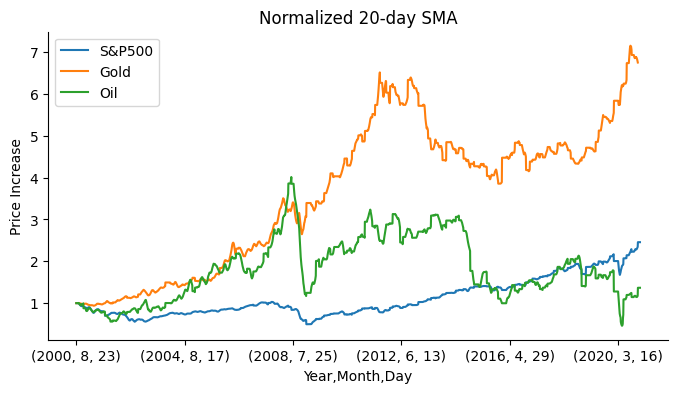

In [17]:
legend_text = ['S&P500', 'Gold', 'Oil']
ax = range_asset_df[[*sma_cols.values()]].plot(kind='line', figsize=(8, 4), title=f'Normalized {rolling_period}-day SMA')
ax.set_ylabel('Price Increase')
ax.legend(legend_text)
plt.gca().spines[['top', 'right']].set_visible(False)


display(range_asset_df[[*sma_cols.values()]].iloc[rolling_period : rolling_period + 3])

##### **Conclusion**:

Plotting the normalized SMA for each asset class over a set period and rolling window shows their relative growth and price trends. This approach helps compare performance and volatility across different assets consistently.

---

### **Percent Change & Cummulative (Total) Return**

Percentage change is a metric that helps investors measure how well an asset performs, like a stock, commodity, or other investment, over a certain period[^1].

This method is not limited to investments; percentage change can also show how the value of everyday items changes. For example, it can track how much the price of oil or gold has increased or decreased over time.

* Analysts and investors use percentage change to look at the growth or drop in asset value over time.
* Tracking percentage changes across different assets helps investors make better decisions about adjustments or rebalancing in their portfolios.
* Percentage change is a useful tool for evaluating price shifts in investments, commodities, and other financial measures.

The formula to calculate the percentage change in price is:

$$
\text{Percentage Change} = \frac{P_{\text{current}} - P_{\text{previous}}}{P_{\text{previous}}} \times 100
$$

where:  
- $P_{\text{current}}$ = Current price or value  
- $P_{\text{previous}}$ = Previous price or value

Similarly,

The formula to calculate **cumulative (total) return** from a series of daily percentage changes ($r_1, r_2, ..., r_n$) is[^2]:

$$
\text{Cumulative Return} = \left( \prod_{i=1}^{n} (1 + r_i) \right) - 1
$$

where:  
- $r_i$ = Daily return (as a decimal, e.g., 0.01 for 1%) on day $i$  
- $n$ = Total number of days

---

[^1]: Investopedia. "Percentage Change: Definition, Formula, and Examples." [https://www.investopedia.com/terms/p/percentage-change.asp](https://www.investopedia.com/terms/p/percentage-change.asp)<br/>
[^2]: Investopedia. "Cumulative Return: Definition, Calculation, and Example." [https://www.investopedia.com/terms/c/cumulativereturn.asp](https://www.investopedia.com/terms/c/cumulativereturn.asp)

In [18]:
perc_cols = {f'{x}' : f"""{x.replace('_Close', '')}_%Return""" for x in close_cols}
cum_cols = {f'{x}' : f"""{x.replace('_%Return', '')}_%CumReturn""" for x in perc_cols.values()}
range_asset_df = pd.concat([range_asset_df,
                            range_asset_df[[*perc_cols.keys()]]
                            .pct_change(fill_method=None).multiply(100)
                            .rename(columns=perc_cols)
                            ], axis=1)
range_asset_df = pd.concat([range_asset_df,
                            ((1 + range_asset_df[[*perc_cols.values()]].divide(100))
                            .cumprod() - 1).multiply(100)
                            .rename(columns=cum_cols)
                            ], axis=1)

S&P500_%CumReturn  Gold_%CumReturn  Oil_%CumReturn
Year Month Day                                                    
2000 8     24            0.310752         0.652884   -1.310453e+00
           25            0.269318         1.051868   -1.110223e-14
           28            0.611146         1.015597    2.558501e+00

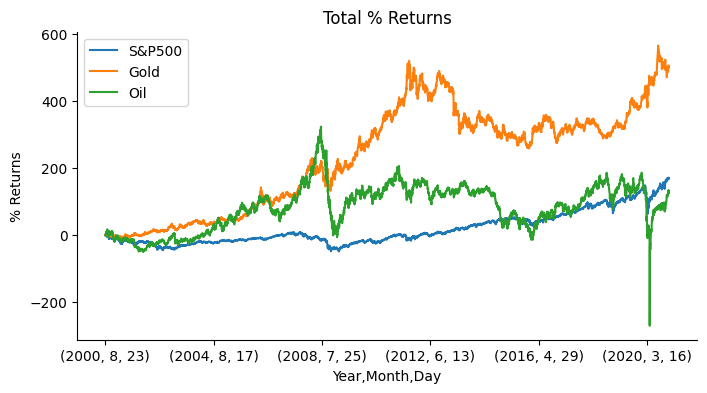

In [19]:
ax = range_asset_df[[*cum_cols.values()]].plot(kind='line', figsize=(8, 4), title=f'Total % Returns')
ax.set_ylabel('% Returns')
ax.legend(legend_text)
plt.gca().spines[['top', 'right']].set_visible(False)

display(range_asset_df[[*cum_cols.values()]].iloc[1:4])

##### **Conclusion**:

Plotting cumulative returns for a group of assets over a user-defined period shows how each asset's performance has changed compared to its starting value. Because the analysis relies on the chosen time frame, the results are specific to that historical period. This provides useful insight into long-term growth, volatility, and times of both outperformance and underperformance among different assets.

---

### **Monthly Distribution of Daily Market Direction**

Monthly Distribution of Daily Market Direction categorizes each trading day based on the direction of returns for all selected assets:

* If all assets move up on a given day, it gets labeled as **"Upward"**.  
* If all assets move down, it is labeled as **"Downward"**.  
* If the assets do not all move in the same direction, the day is classified as **"Mixed"**.

The results are then combined by month showing the percentage of days in each category.

This analysis helps to understand:
* Monthly patterns of market agreement (when assets move together) or disagreement (when assets move in different directions)
* Changes in market momentum across time
* The presence of seasonal effects in asset movements
* The level of connection or independence between different assets

The formula to calculate such a trend is as follows:  

Let $N_{m,T}$ be the number of days in month $m$ classified as trend $T$ (where $T$ is Upward, Downward, or Mixed), and $N_m$ be the total number of trading days in month $m$.

The percentage of days in month $m$ with trend $T$ is:

$$
\text{Percentage}_{m,T} = \frac{N_{m,T}}{N_m} \times 100
$$

where:
- $N_{m,T}$ = Number of days in month $m$ with trend $T$
- $N_m$ = Total number of trading days in month $m$

In [20]:
def overall_trend(row):
  row_t_count = row.count()
  if row.isna().any():
    return ''
  elif (row > 0).sum() == row_t_count:
    return 'Upward'
  elif (row < 0).sum() == row_t_count:
    return 'Downward'
  else:
    return 'Mixed'

overall_trend_df = range_asset_df[[*perc_cols.values()]].reset_index()
overall_trend_df['OverAll_Trend'] = overall_trend_df[[*perc_cols.values()]].apply(overall_trend, axis=1)
overall_trend_df = overall_trend_df[~overall_trend_df['OverAll_Trend'].str.fullmatch('')]
overall_pivot_df = pd.pivot_table(overall_trend_df[['Month', 'OverAll_Trend', 'S&P500_%Return']], index='Month', columns='OverAll_Trend', aggfunc='count')
overall_pivot_df.columns = [a[1] for a in overall_pivot_df.columns.to_flat_index()]
overall_pivot_df = overall_pivot_df.divide(overall_pivot_df.sum(axis=1), axis=0).multiply(100)

,Downward,Mixed,Upward
Month,,,
1,12.928760,69.656992,17.414248
2,12.359551,70.224719,17.415730
3,14.712644,66.436782,18.850575


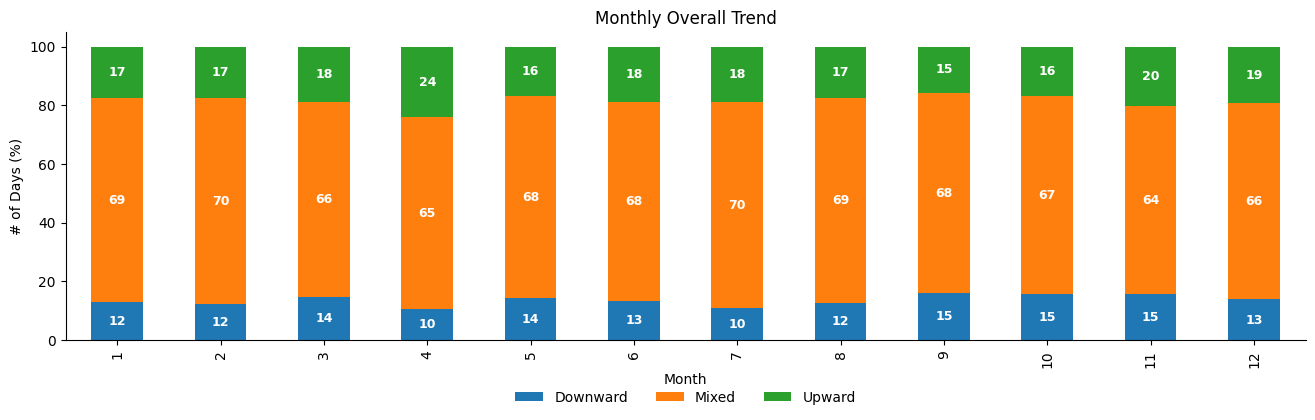

In [21]:
ax = overall_pivot_df.plot(kind='bar', figsize=(16, 4), title=f'Monthly Overall Trend', stacked=True)
ax.set_ylabel('# of Days (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

for bar_container in ax.containers:
    for bar in bar_container:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                        ha='center', va='center', color='white', fontsize=9, fontweight='bold')

ax.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    frameon=False
)

display(overall_pivot_df.head(3))

##### **Conclusion**:

Over the selected period, most months experienced a high percentage of “Mixed days. This suggests that the assets often moved independently. Months with more “Upward” or “Downward” days indicate times of strong market momentum.

---

### Correlation Coefficient for Monthly Returns - **Pearson's Correlation Coefficient**

The correlation coefficient is a number that shows how closely two assets move together. It ranges from -1 to 1[^1]:
- **1** means the assets always move in the same direction.
- **-1** means they always move in opposite directions.
- **0** means there is no connection between their movements.

This measure helps investors see if assets like gold and oil move together or independently. If the correlation is close to zero, the assets move separately, which can help lower risk in a portfolio.

**Key Points:**
- Correlation coefficients reveal the degree of association between asset returns.
- The **Pearson correlation coefficient** is the most widely used measure for assessing linear relationships.
- Values near -1 or 1 indicate strong relationships, while values near zero suggest weak or no linear association.
- The relevance of a particular coefficient value depends on the analysis context and can be further evaluated using statistical significance tests.

The Pearson correlation coefficient $r_{XY}$ between two variables (or asset returns) $X$ and $Y$ is calculated as:

$$
r_{XY} = \frac{\sum_{i=1}^n (X_i - \bar{X}) (Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^n (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^n (Y_i - \bar{Y})^2}}
$$

where:
- $X_i$ and $Y_i$ are the individual sample points,
- $\bar{X}$ and $\bar{Y}$ are the sample means,
- $n$ is the number of observations.

---

[^1]: Investopedia. "Correlation Coefficient: Definition, Calculation, and Example." [https://www.investopedia.com/terms/c/correlationcoefficient.asp](https://www.investopedia.com/terms/c/correlationcoefficient.asp)



In [22]:
corr_cols = {f'{x}' : f"""{x.replace('_%Return', '')}_Corr""" for x in perc_cols.values()}
corr_df = range_asset_df[[*corr_cols.keys()]].groupby(level=[1]).corr().unstack()
corr_df.columns = [f"""{"_".join(a).replace('_%Return', '')}_Corr""" for a in corr_df.columns.to_flat_index()]
corr_df = corr_df[['S&P500_Gold_Corr', 'S&P500_Oil_Corr', 'Gold_Oil_Corr']]

,S&P500_Gold_Corr,S&P500_Oil_Corr,Gold_Oil_Corr
Month,,,
1,-0.039107,0.312320,0.182149
2,-0.047966,0.166695,0.057820
3,0.068569,0.332126,0.252484


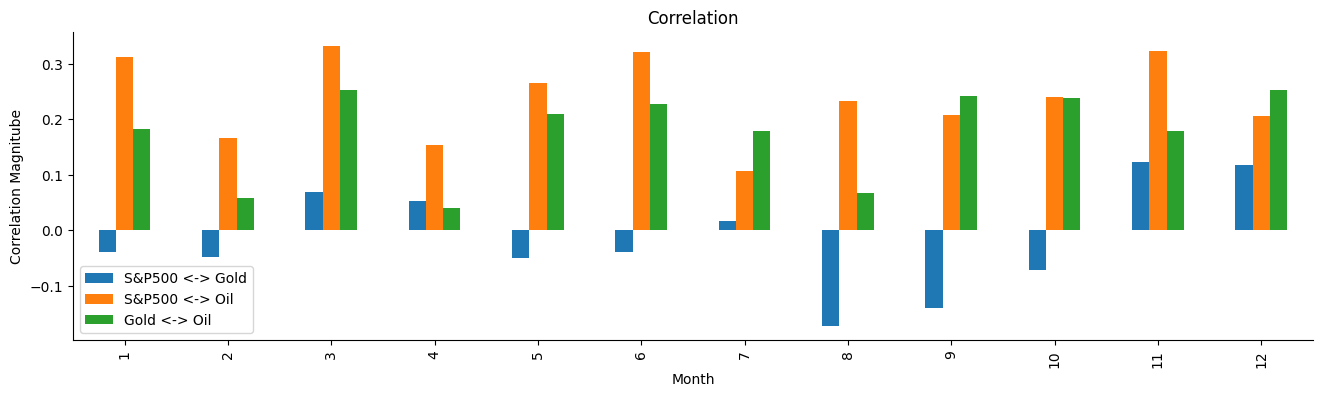

In [23]:
ax = corr_df.plot(kind='bar', figsize=(16, 4), title=f'Correlation')
ax.set_ylabel('Correlation Magnitube')
ax.legend(['S&P500 <-> Gold', 'S&P500 <-> Oil', 'Gold <-> Oil'])
plt.gca().spines[['top', 'right']].set_visible(False)

display(corr_df.head(3))

##### **Conclusion**:

Monthly Pearson correlation coefficients reveal that the relationships between the returns of the S&P 500, Gold, and Oil tend to be moderate or weak and they can fluctuate quite a bit over time. When correlations are higher it often points to common market influences whereas lower or even negative correlations suggest that these assets are moving more independently. Keeping an eye on these changes is crucial for effective diversification and managing risk.

---

### **Average Monthly Returns**

This section calculates the average percentage return for each asset (S&P 500, Gold, Oil) in each calendar month, averaged across all years in the selected period[^1].

By grouping returns by month  you can identify recurring seasonal trends or patterns in asset performance.
This analysis helps investors spot months that historically tend to have higher or lower returns for each asset.

The calculation is as follows:

Let $R_{i,m}$ be the return for asset $i$ in month $m$ for each year, and $n_m$ be the number of years with data for month $m$.

The average monthly return for asset $i$ in month $m$ is:

$$ \text{Average Return}{i,m} = \frac{1}{n_m} \sum{k=1}^{n_m} R_{i,m}^{(k)} $$

where:

* $R_{i,m}^{(k)}$ = Return for asset $i$ in month $m$ of year $k$
* $n_m$ = Number of years with data for month $m$

---
[^1]: Investopedia. "Average Return: Meaning, Calculations and Examples" [https://www.investopedia.com/terms/a/averagereturn.asp](https://www.investopedia.com/terms/a/averagereturn.asp)


In [24]:
monthlyReturns = range_asset_df[[*perc_cols.values()]].groupby(['Year', 'Month']).sum().groupby('Month').mean()
monthlyReturns.head(3)

,S&P500_%Return,Gold_%Return,Oil_%Return
Month,,,
1,0.404372,3.203198,0.771125
2,-0.204774,1.120590,3.058619
3,0.326490,-0.174139,0.100080


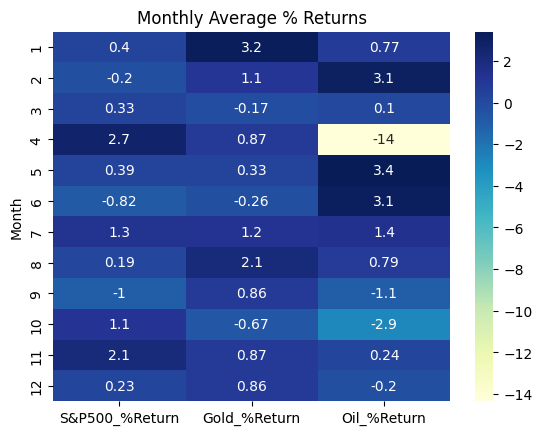

,S&P500_%Return,Gold_%Return,Oil_%Return
Month,,,
1,0.404372,3.203198,0.771125
2,-0.204774,1.120590,3.058619
3,0.326490,-0.174139,0.100080


In [25]:
ax = sb.heatmap(monthlyReturns, annot=True, cmap="YlGnBu")
ax.set_title('Monthly Average % Returns')
plt.show()

display(monthlyReturns.head(3))

##### **Conclusion**:

Calculating and visualizing average monthly returns helps reveal which months tend to be stronger or weaker for each asset. This can guide seasonal investment strategies and highlight periods of consistent outperformance or underperformance. The S&P 500 and Gold generally deliver positive average returns in most months with the S&P 500 performing especially well. Oil, however, shows much greater volatility with weak or negative performance.

---

### **Alpha (α) Beta (β) Calculations**

Alpha and beta are key metrics in finance for evaluating asset performance relative to a benchmark (here, the S&P 500)[^1}:

Beta measures an asset's sensitivity to movements in the benchmark.
* β > 1 means the asset is more volatile than the market.
* β < 1 means less volatile.
* β = 0 means the stock's moves don’t correlate with the broader market

Alpha measures the asset's excess return compared to what would be predicted by its beta.
* Positive α means outperformance.
* negative α means underperformance.

The formulas used are:

Beta:
$$ \beta = \frac{\text{Covariance}(\text{asset}, \text{benchmark})}{\text{Variance}(\text{benchmark})} $$

Alpha:
$$ \alpha = \text{Average return of asset} - (\beta \times \text{Average return of benchmark}) $$

This section computes and displays the alpha and beta values for Gold and Oil compared to the S&P 500.

---

[^1]: Investopedia. "Alpha and Beta for Beginners" [https://www.investopedia.com/articles/investing/092115/alpha-and-beta-beginners.asp](https://www.investopedia.com/articles/investing/092115/alpha-and-beta-beginners.asp)

In [26]:
beta_df = monthlyReturns.cov().iloc[0]/monthlyReturns.var().iloc[0]
alpha_beta_df = pd.DataFrame({'Beta' : beta_df,
                              'Alpha' : monthlyReturns.mean() - beta_df * monthlyReturns['S&P500_%Return'].mean()},
                             index=beta_df.index)

def alpha_beta_plot(ab_df, alpha_col, beta_col, id_name, base_id_name, y_label, x_label, title):
  alpha = ab_df.loc[id_name, alpha_col];
  beta = ab_df.loc[id_name, beta_col];
  ax = sb.regplot(x=base_id_name, y=id_name, data=monthlyReturns);
  ax.plot([0, 0], [0, alpha], color='red', linewidth=2);
  ax.plot(0, alpha, marker='x', color='red', markersize=10, markeredgewidth=3);
  ax.spines['bottom'].set_position('zero');
  ax.spines['left'].set_position('zero');
  sb.despine();
  ax.set_xlabel(x_label);
  ax.set_ylabel(y_label);
  ax.xaxis.set_label_coords(0.5, -0.07);
  ax.yaxis.set_label_coords(-0.07, 0.5);
  ax.annotate(
    f'$\\alpha$ = {alpha: .2f}',
    xy=(0, alpha),
    xytext=(-0.9, 1.5),
    textcoords='data',
    color='black',
    fontsize=9,
    arrowprops=dict(
        arrowstyle='->',
        color='black',
        lw=1,
        shrinkA=0, shrinkB=0
    )
  );

  ax.annotate(
    f'$\\beta$ = {beta: .2f}',
    xy=(0.5, alpha + (beta * 0.5)),
    xytext=(0.5, 2),
    textcoords='data',
    color='black',
    fontsize=9,
    arrowprops=dict(
        arrowstyle='->',
        color='black',
        lw=1,
        shrinkA=0, shrinkB=0
    )
  );
  ax.set_title(f"Alpha ($\\alpha$) - Beta ($\\beta$ - Slope) of {title} Monthly Returns");

**Regression plots** on **monthly average returns** to interpret the **alpha** and **beta** for Gold and Oil relative to the S&P 500:

* The slope of the regression line represents beta showing how much the asset moves in response to the market.
* The intercept on the y-axis represents alpha, showing the asset's excess return independent of the market.

These plots help demonstrate how each asset responds to movements in the broader market and allows us to visualise the alpha-beta relationship

In [34]:
alpha_beta_df

,Beta,Alpha
S&P500_%Return,1.000000,1.110223e-16
Gold_%Return,0.019326,8.526212e-01
Oil_%Return,-2.793717,1.114315e+00


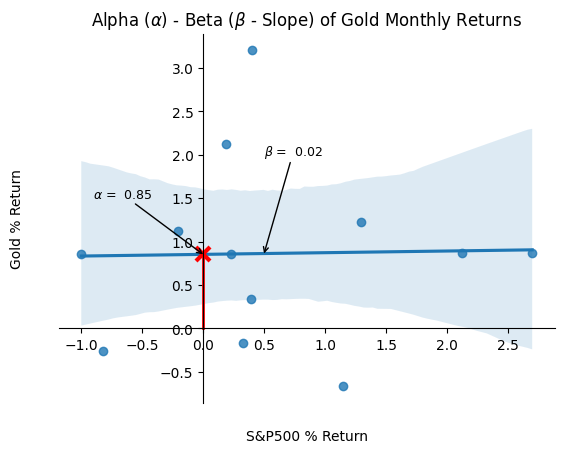

In [35]:
alpha_beta_plot(alpha_beta_df, 'Alpha', 'Beta', 'Gold_%Return', 'S&P500_%Return', 'Gold % Return', 'S&P500 % Return', 'Gold')

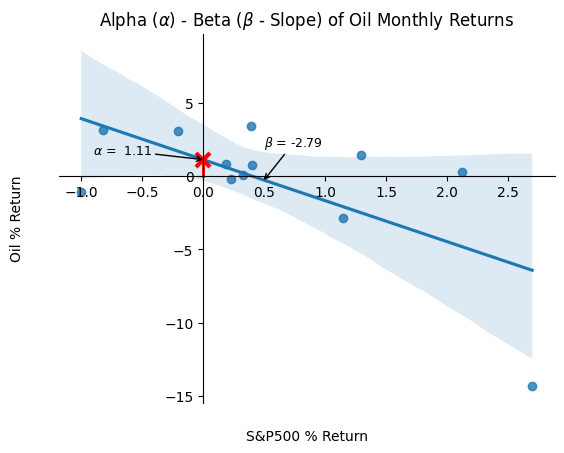

In [36]:
alpha_beta_plot(alpha_beta_df, 'Alpha', 'Beta', 'Oil_%Return', 'S&P500_%Return', 'Oil % Return', 'S&P500 % Return', 'Oil')

##### **Conclusion**:

Alpha and beta provide a concise summary of how each asset behaves relative to the market. High beta indicates greater sensitivity to market moves while positive alpha suggests the asset tends to outperform the market after accounting for risk.

Gold’s returns do not change much when the S&P 500 moves so gold is a good way to diversify a portfolio and lower risk. Its beta is close to zero meaning it is not very sensitive to stock market ups and downs but its positive alpha shows it can still add value over time.

Oil on the other hand usually moves in the opposite direction of the S&P 500 (negative beta), so when stocks go up, oil often goes down, and vice versa. Even with this negative relationship, oil’s positive alpha means it can still provide good returns on average.

Together, gold and oil can help balance a portfolio because they behave differently from stocks and from each other. This mix can help protect against big losses when the stock market is volatile.

---

# Export Assets Dataframe To Excel File


The final section includes code to export the full asset performance DataFrame to an Excel file.

This is meant to be run locally, not in Colab. Download the notebook and uncomment the code before running.

In [32]:
# assets_df.to_excel('exported_dataset.xlsx', index=True, header=True)